<a href="https://colab.research.google.com/github/438-venkatesh/SIH_2K24_Project/blob/main/Delay_Prediction(CLSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, Attention, LayerNormalization, Concatenate,Flatten,Conv1D,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Multiply

In [ ]:
data = pd.read_csv('/content/bus_delay_data - bus_delay_data.csv')
X = data[['Time','Traffic Density (vehicles/km)','Bus Speed (km/h)','Weather Type']]
y = data['Historical Delay (min)']

In [ ]:
def time_to_float(time_str):
    try:
      time_obj = datetime.strptime(time_str, '%H:%M:%S')
      return time_obj.hour + time_obj.minute / 60.0 + time_obj.second / 3600.0
    except ValueError:
      print(f"Invalid time format: {time_str}")
      return None

In [ ]:
X['time_float'] = X['Time'].apply(time_to_float)
X = X.drop(columns=['Time'])

#X = pd.get_dummies(X, columns=['Weather Type'], prefix='Weather')

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)



In [ ]:
X_train.shape[1]

1

In [ ]:
X_train.shape[2]

4

In [ ]:
def clstm_model_builder(hp):
    input_layer = Input(shape=(X_train.shape[1],4))

    # 1D Convolutional Layer for feature extraction
    hp_filters = hp.Int('filters', min_value=16, max_value=128, step=16)
    hp_kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    conv1 = Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='elu',
                   padding='same', kernel_initializer='he_normal')(input_layer)
    conv1 = LayerNormalization()(conv1)

    # First Bidirectional LSTM Layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
    lstm1 = Bidirectional(LSTM(units=hp_units1, return_sequences=True,
                               kernel_initializer='he_normal'))(conv1)
    ln1 = LayerNormalization()(lstm1)

    # Residual connection from conv1 to lstm1 output
    residual1 = Concatenate()([conv1, ln1])

    # Second Bidirectional LSTM Layer
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
    lstm2 = Bidirectional(LSTM(units=hp_units2, return_sequences=True,
                               kernel_initializer='he_normal'))(residual1)
    ln2 = LayerNormalization()(lstm2)

    # Attention Mechanism
    attention = GlobalAveragePooling1D()(ln2)
    attention = Dense(hp_units2, activation='elu')(attention)
    attention = Dense(X_train.shape[1], activation='softmax')(attention)
    attention = Reshape((X_train.shape[1], 1))(attention)
    attention_output = Multiply()([ln2, attention])

    # Final Dense Layer after Attention
    ln3 = LayerNormalization()(attention_output)
    ln3 = Dropout(rate=hp.Choice('dropout', values=[0.2, 0.3, 0.4]))(ln3)
    dense_output = Dense(64, activation='elu', kernel_initializer='he_normal')(ln3)
    dense_output = Dense(1, activation='linear', kernel_initializer='he_normal')(dense_output)

    # Output Layer
    output = Dense(1, activation='linear')(dense_output)

    model = Model(inputs=input_layer, outputs=output)

    # Optimizer with Learning Rate Tuning
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    optimizer = Adam(learning_rate=hp_learning_rate)

    # Compile Model with Parameterized Huber Loss
    hp_delta = hp.Choice('delta', values=[0.5, 1.0, 1.5])
    model.compile(optimizer=optimizer, loss=Huber(delta=hp_delta))

    return model

In [ ]:
tuner = kt.RandomSearch(
    clstm_model_builder,
    objective='val_loss',
    max_trials=10,  # Reduced max_trials for faster tuning
    executions_per_trial=1, # Increase to 2 or 3 for increased reliability
    overwrite = True, # Add this to avoid error if running multiple times
    directory='my_dir_clstm',
    project_name='tune_clstm'
)

In [ ]:
tuner.search(X_train, y_train_scaled, epochs=50, validation_data=(X_test, y_test_scaled),
             callbacks=[EarlyStopping(patience = 10)], verbose =1)

Trial 10 Complete [00h 00m 29s]
val_loss: 0.03177684172987938

Best val_loss So Far: 0.007567976135760546
Total elapsed time: 00h 09m 46s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=best_hps.get("units1"),  validation_data=(X_test, y_test_scaled),
                    callbacks=[early_stopping, lr_schedule], verbose =1)

model.save("final.h5")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - loss: 0.1467 - val_loss: 0.0494 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0382 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0360 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0335 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0337 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0324 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0307 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0297 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0292 - val_loss: 0.0348 - learning_rate: 0.0010
Epoch 10/100
8/8 ━━━━━━━━━

In [ ]:
predictions_scaled = model.predict(X_test)
predictions_scaled = predictions_scaled.reshape(-1, 1)
predictions = scaler_y.inverse_transform(predictions_scaled)

mse = mean_squared_error(scaler_y.inverse_transform(y_test_scaled), predictions)
rmse = np.sqrt(mse)
r2 = r2_score(scaler_y.inverse_transform(y_test_scaled), predictions)
print(f"MSE: {mse}, RMSE: {rmse}, R2: {r2}")

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
MSE: 0.8893825073362239, RMSE: 0.9430707859626571, R2: 0.89912331954293


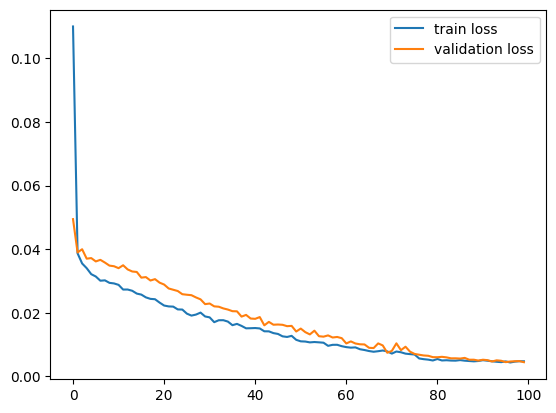

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
df_delays = pd.DataFrame({
    'Actual Delay (minutes)': scaler_y.inverse_transform(y_test_scaled).flatten(),
    'Predicted Delay (minutes)': predictions.flatten()
})

In [ ]:
print(df_delays.head(20))

    Actual Delay (minutes)  Predicted Delay (minutes)
0                      8.0                   7.948194
1                      1.0                   0.698742
2                     10.0                   7.996514
3                      5.0                   6.291009
4                     10.0                   9.664246
5                      5.0                   6.291009
6                      0.0                   0.224029
7                      5.0                   4.922752
8                      3.0                   4.461099
9                      7.0                   5.273107
10                     9.0                   8.840487
11                     3.0                   2.293165
12                    10.0                   9.862350
13                     2.0                   1.266753
14                     4.0                   2.451283
15                     5.0                   6.291009
16                     5.0                   4.739423
17                     3.0  

#Testing delay prediction



In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/final.h5")
def time_to_float(time_str):
    try:
      time_obj = datetime.strptime(time_str, '%H:%M:%S')
      return time_obj.hour + time_obj.minute / 60.0 + time_obj.second / 3600.0
    except ValueError:
      print(f"Invalid time format: {time_str}")
      return None
p=["9:30:00","120","5.5","0"]
p[0]=time_to_float(p[0])
p = [float(i) for i in p]
p=np.array(p).reshape(1,1,4)
o=model.predict(p)
o = scaler_y.inverse_transform(o.reshape(-1,1))
print(f"{o[0][0]:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1.60


1.60
